### [1] 사전준비 (모델 구조 & 튜닝위치)

### [1-1] 모델구조 확인

In [26]:
import torch
import torchvision.models as models

# ResNet18 모델 불러오기 (pretrained=True로 사전학습된 가중치 사용)
model = models.resnet18(weights="IMAGENET1K_V1")

In [27]:
# 1. 전체 모델 구조 출력
print("ResNet18 전체 구조")
print(model)

ResNet18 전체 구조
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(i

In [34]:
model.layer4
model.layer4[1]

BasicBlock(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [40]:
len(list(model.named_modules())) # 전체모델 갯수

68

In [41]:
# 2. 모델의 주요 레이어 확인
print("\n" + "=" * 50)
print("ResNet18 주요 레이어")
print("=" * 50)
for bun, (name, module) in enumerate(model.named_children()):
    print(f"{bun} -> {name}: {module.__class__.__name__}")




ResNet18 주요 레이어
0 -> conv1: Conv2d
1 -> bn1: BatchNorm2d
2 -> relu: ReLU
3 -> maxpool: MaxPool2d
4 -> layer1: Sequential
5 -> layer2: Sequential
6 -> layer3: Sequential
7 -> layer4: Sequential
8 -> avgpool: AdaptiveAvgPool2d
9 -> fc: Linear


In [48]:
# 입력과 출력층
print(f'.first_layer(input): \n {model.conv1}')
print(f'\n.last_layer(output): \n{model.fc}')


.first_layer(input): 
 Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

.last_layer(output): 
Linear(in_features=512, out_features=1000, bias=True)


In [138]:
# model.summary로 shape확인가능
print(list(model.conv1.parameters())[0].shape)

torch.Size([64, 3, 7, 7])


In [130]:
 # 참고:  커널사이즈 7*7, 피처값 [63]은 64번째 [2]는 RGB에서 B에들어가는값
 list(model.conv1.parameters())[0][63][2]

tensor([[-0.0057,  0.0134, -0.0265, -0.0112,  0.0045,  0.0021,  0.0139],
        [ 0.0066,  0.0452,  0.0603,  0.0707,  0.0144, -0.0051,  0.0041],
        [ 0.0553,  0.1240,  0.0432, -0.1289, -0.1449, -0.0745, -0.0575],
        [ 0.0536, -0.0466, -0.2823, -0.2911, -0.0485,  0.0590,  0.0341],
        [-0.0315, -0.1633, -0.1579,  0.0987,  0.2290,  0.1202,  0.0720],
        [-0.0105, -0.0011,  0.0846,  0.1945,  0.1575,  0.0221, -0.0101],
        [-0.0049, -0.0050,  0.0363,  0.0406, -0.0244, -0.0712, -0.0668]],
       device='cuda:0')

### [1-2] 튜닝위치 확인(샘플이미지로)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


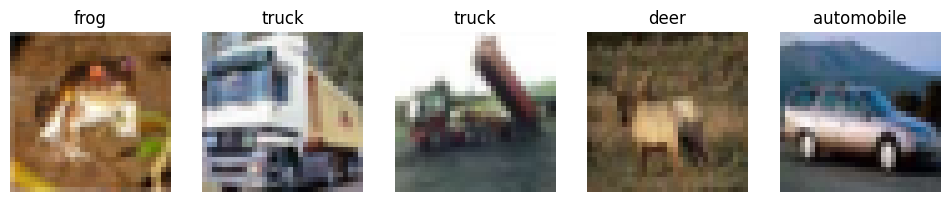

In [54]:
#################################
## 데이터셋 확인
################################
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

# 1. 변환 정의 (Tensor로만 변환)
transform = transforms.ToTensor() # 정규화 하는 자료임

# 2. CIFAR-10 불러오기 (train 세트만 예시)
dataset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)

# 3. 샘플 몇 개 뽑기
classes = dataset.classes  # ['airplane', 'automobile', ... 'truck']
print(classes) #클래스 갯수 10개임

fig, axes = plt.subplots(1, 5, figsize=(12,3))
for i in range(5):
    img, label = dataset[i]
    axes[i].imshow(img.permute(1,2,0))  # (C,H,W) → (H,W,C)
    axes[i].set_title(classes[label])
    axes[i].axis("off")
plt.show()


torch.Size([32, 32, 3]) tensor(0.) ~ tensor(0.9961)


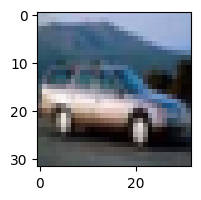

In [65]:
# 특징맵에 사용할 테스트 이미지
testimg=dataset[4][0]
testimg=testimg.permute(1,2,0)
plt.figure(figsize=(2,2))
print(testimg.shape, testimg.min(), '~', testimg.max())
plt.imshow(testimg)

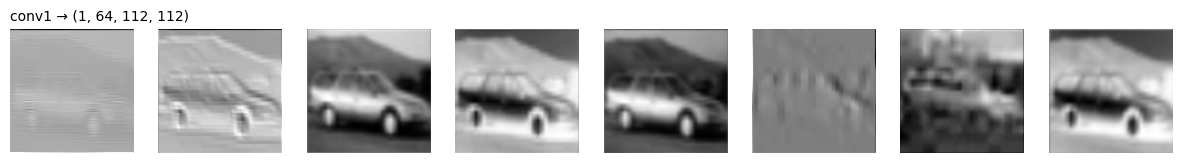

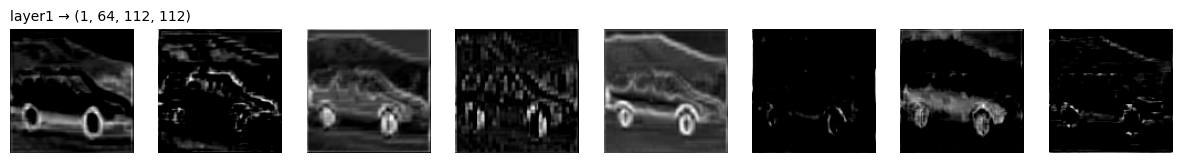

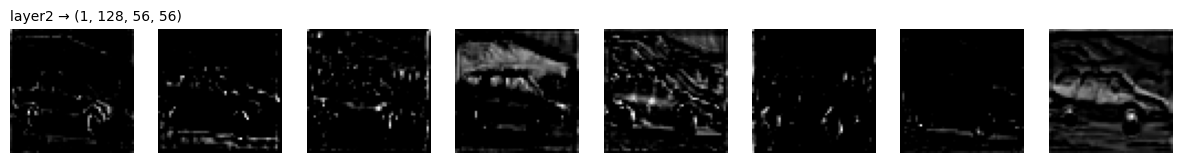

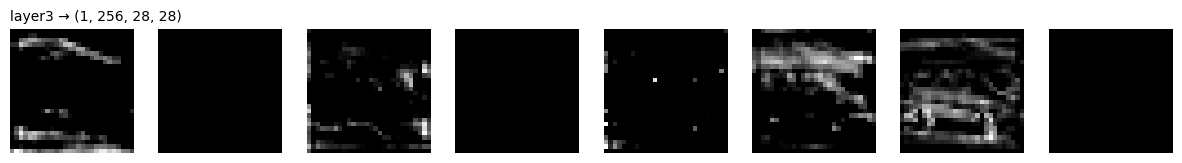

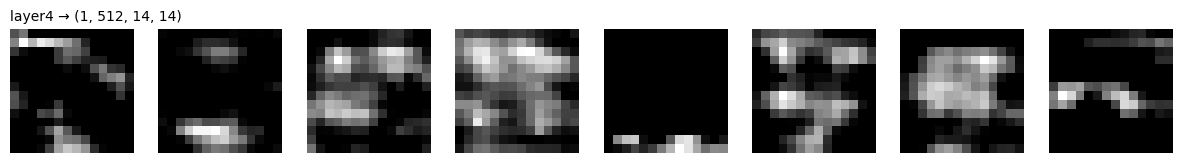

In [69]:
###########################################
## 튜닝할 위치 확인
###########################################
import torch
import matplotlib.pyplot as plt
from torchvision import models, transforms
import torch.nn.functional as F

# 1. 모델 준비 (ResNet18, ImageNet 가중치)
model = models.resnet18(weights="IMAGENET1K_V1")
model.eval()

# 2. ImageNet 전처리 (Tensor용)
transform = transforms.Compose([
    transforms.Lambda(lambda img: img.permute(2,0,1)),  # HWC → CHW
    transforms.Resize((224,224)),                       # 32x32 → 224x224
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

# 3. testimg 준비 (torch.Size([32,32,3]), 값 범위 0~1)
x = transform(testimg).unsqueeze(0)   # [1, 3, 224, 224]

# 4. 중간 레이어 feature map 추출 & 시각화
layers = dict(model.named_children())

def show_feature(name, out, max_channels=8):
    fmap = out.squeeze(0).detach().cpu()
    num = min(max_channels, fmap.shape[0])
    fig, axes = plt.subplots(1, num, figsize=(15,4))

    for i, ax in enumerate(axes if num>1 else [axes]):
        ax.imshow(fmap[i], cmap="gray")
        ax.axis("off")

    axes[0].set_title(f"{name} → {tuple(out.shape)}", fontsize=10, loc="left")
    plt.show()

out = x
for name in ["conv1", "layer1", "layer2","layer3","layer4"]:
    out = layers[name](out)
    show_feature(name, out)


### [2] 사전학습모델 resnet18을 이용한전이학습
- Layer3번부터 학습하기로함
- 마지막레이어의 출력갯수는 10개임으로 사전학습의 1000개를 변경해야함



#### [2-1] 데이터셋 준비
- CiFAR 10 모델, 사물분류

In [83]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import numpy as np
import matplotlib.pyplot as plt
#from torchinfo import summary

In [89]:

# 장치 선택 (GPU 있으면 cuda, 없으면 cpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# res18 의 224 사이즈 만들고, 정규화는 res18 doc에서 정의되어 있음.
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

# 훈련 데이터 (50,000장)
train_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)

# 테스트 데이터 (10,000장)
test_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

print("Train size:", len(train_dataset))  # 50000
print("Test size:", len(test_dataset))    # 10000
className=train_dataset.classes
print(className) #클래스갯수 10개

Train size: 50000
Test size: 10000
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [90]:
######################################
# 데이터로더
#####################################
batch_size = 64  # 원하는 값으로 조절 가능

# DataLoader
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
)

test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)

print("배치 크기:", batch_size)
print("train 배치 개수:", len(train_loader))
print("test 배치 개수:", len(test_loader))

배치 크기: 64
train 배치 개수: 782
test 배치 개수: 157


#### [2-2] 모델 출력층 수정 & 레이어 훈련 위치 지정
- model.fc 출력해보면
    - Linear(in_features=512, out_features=1000, bias=True)

In [169]:
model = models.resnet18(weights="IMAGENET1K_V1")


# 레이어 학습, 동결 구분
for name, param in model.named_parameters():
    if name.startswith(("layer3", "layer4", "fc")):
        param.requires_grad = True
    else:
        param.requires_grad = False

# . 출력 클래스 개수에 맞게 fc 수정 (예: CIFAR-10 → 10클래스)
model.fc = nn.Linear(model.fc.in_features, 10)
model.to(device)

# . 손실함수와 옵티마이저: requires_grad=True인 파라미터만 업데이트

criterion = nn.CrossEntropyLoss()

params_to_update=[]
for p in model.parameters():
  if p.requires_grad:
    params_to_update.append(p)

# params_to_update = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(params_to_update, lr=1e-4)


In [146]:
num_epochs = 5
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(num_epochs):
    # -------------------
    # Train
    # -------------------
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Train accuracy도 같이 기록
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = correct / total
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    # -------------------
    # Eval (Test)
    # -------------------
    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_test_loss = test_loss / len(test_loader)
    epoch_test_acc = correct / total
    test_losses.append(epoch_test_loss)
    test_accuracies.append(epoch_test_acc)

    # -------------------
    # Logging
    # -------------------
    print(f"[Epoch {epoch+1}] "
          f"Train Loss: {epoch_train_loss:.4f} | "
          f"Train Acc: {epoch_train_acc*100:.2f}% | "
          f"Test Loss: {epoch_test_loss:.4f} | "
          f"Test Acc: {epoch_test_acc*100:.2f}%")

[Epoch 1] Train Loss: 0.0173 | Train Acc: 99.40% | Test Loss: 0.2910 | Test Acc: 92.93%
[Epoch 2] Train Loss: 0.0122 | Train Acc: 99.61% | Test Loss: 0.2728 | Test Acc: 93.22%
[Epoch 3] Train Loss: 0.0126 | Train Acc: 99.60% | Test Loss: 0.3131 | Test Acc: 92.62%
[Epoch 4] Train Loss: 0.0139 | Train Acc: 99.53% | Test Loss: 0.2976 | Test Acc: 92.98%
[Epoch 5] Train Loss: 0.0094 | Train Acc: 99.69% | Test Loss: 0.3028 | Test Acc: 92.84%


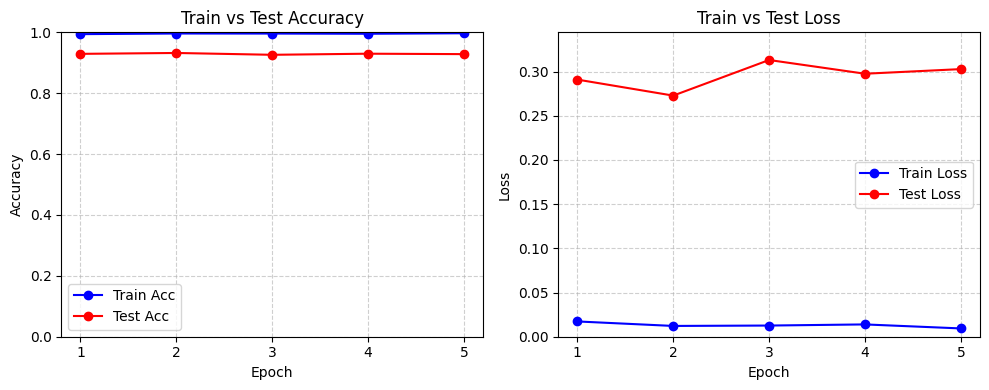

In [159]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses)+1)
plt.figure(figsize=(10,4))

# 1. Accuracy
plt.subplot(1,2,1)
plt.plot(epochs, train_accuracies, "b-o", label="Train Acc")
plt.plot(epochs, test_accuracies, "r-o", label="Test Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy")
plt.ylim(0,1)  # 0~1 범위 고정
plt.xticks(epochs)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

# 2. Loss
plt.subplot(1,2,2)
plt.plot(epochs, train_losses, "b-o", label="Train Loss")
plt.plot(epochs, test_losses, "r-o", label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Test Loss")
plt.ylim(0, max(max(train_losses), max(test_losses)) * 1.1)  # 0부터 시작
plt.xticks(epochs)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()


In [160]:
# 7. 평가
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"테스트 정확도: {100*correct/total:.2f}%")

테스트 정확도: 92.84%


## [3] 추론
- 새로운 데이터를 넣어서 클래스 확인

In [161]:
## 추론


import torch
from PIL import Image
import torchvision.transforms as transforms

# 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 불러오기 (학습된 모델이어야 함)
# model = ...  # 이미 fine-tuning 완료된 모델
model.eval()

# CIFAR-10 클래스 이름
classes = ['plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# 이미지 전처리 (학습 때와 동일하게 맞추는 게 중요!)
transform = transforms.Compose([
    transforms.Resize((224,224)),  # ResNet 입력 크기
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

# 1. 이미지 불러오기
img = Image.open("추론cat.jpg").convert("RGB")

# 2. 전처리 적용 후 배치 차원 추가
input_tensor = transform(img).unsqueeze(0).to(device)

# 3. 추론
with torch.no_grad():
    outputs = model(input_tensor)
    _, predicted = outputs.max(1)

print("예측 클래스:", classes[predicted.item()])

예측 클래스: cat


## [3] 모델 저장 및 다시 불러와 추론

In [168]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image

# -----------------------
# 2. (예시) 학습 후 모델 저장
# -----------------------
# 학습 루프가 끝났다고 가정
torch.save(model.state_dict(), "resnet18_cifar10.pth")
print(" 모델 저장 완료: resnet18_cifar10.pth")

# -----------------------
# 3. 저장된 모델 불러오기
# -----------------------
# 같은 모델 구조를 다시 정의
loaded_model = models.resnet18(weights="IMAGENET1K_V1")
for name, param in loaded_model.named_parameters():
    if name.startswith(("layer3", "layer4", "fc")):
        param.requires_grad = True
    else:
        param.requires_grad = False
loaded_model.fc = nn.Linear(loaded_model.fc.in_features, 10)
loaded_model.load_state_dict(torch.load("resnet18_cifar10.pth", map_location=device))
loaded_model.to(device)
loaded_model.eval()
print("  모델 불러오기 완료")

# -----------------------
# 4. 단일 이미지 추론
# -----------------------
# CIFAR-10 클래스 이름 (datasets.CIFAR10().classes 참고)
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

# 추론할 이미지 불러오기 (32x32짜리 CIFAR-10 이미지라고 가정)
img_path = "추론ship.jpg"   # 원하는 이미지 파일 경로
img = Image.open(img_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((224,224)),   # ResNet 입력 크기
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

x = transform(img).unsqueeze(0).to(device)  # [1,3,224,224]

with torch.no_grad():
    outputs = loaded_model(x)
    _, preds = torch.max(outputs, 1)

print(f" 추론 결과: {class_names[preds.item()]}")


 모델 저장 완료: resnet18_cifar10.pth
  모델 불러오기 완료
 추론 결과: ship


# 새 섹션